In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_data_dir = "/content/drive/MyDrive/EDAN70/Models/Data/main_data/"

Mounted at /content/drive


### Images loading and sorting into control, lps_smaller, lps_larger

110
70
(586, 1335, 3)
(890, 1674, 3)
(586, 1335, 3)
(586, 1335, 3)


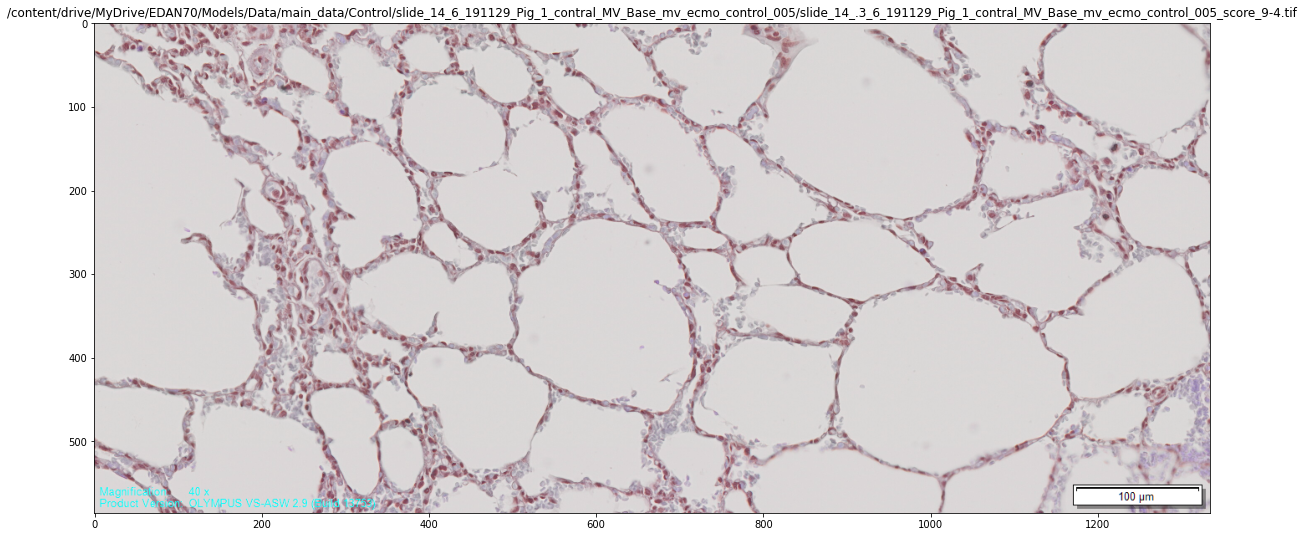

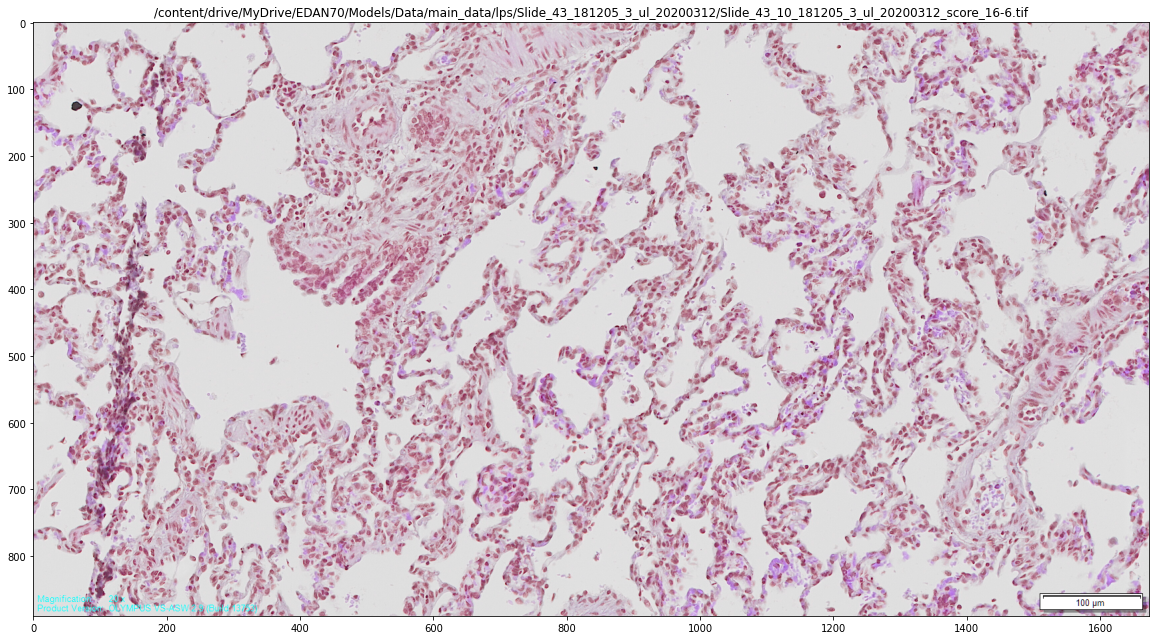

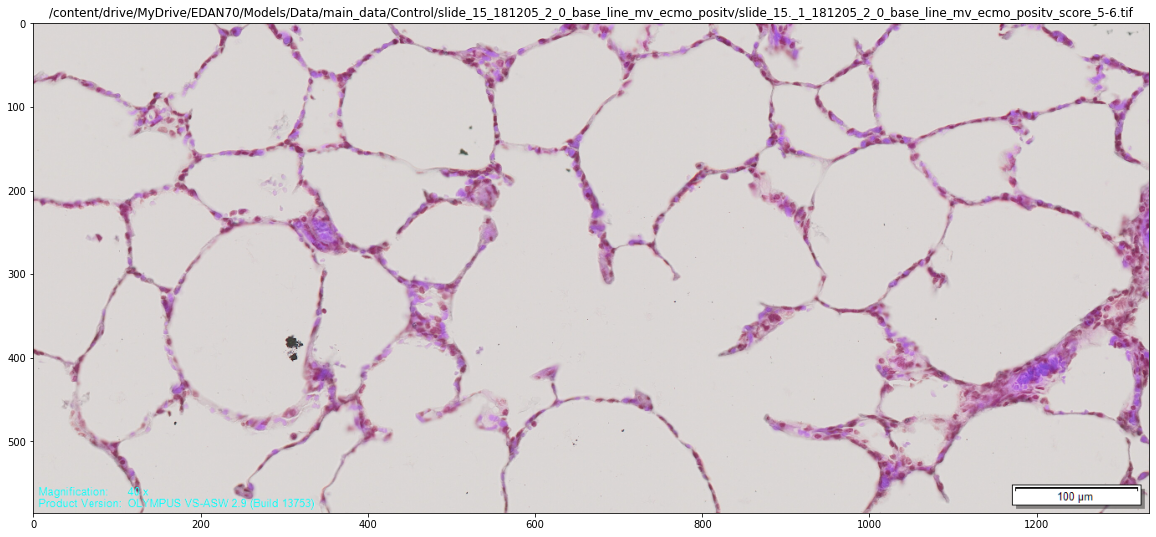

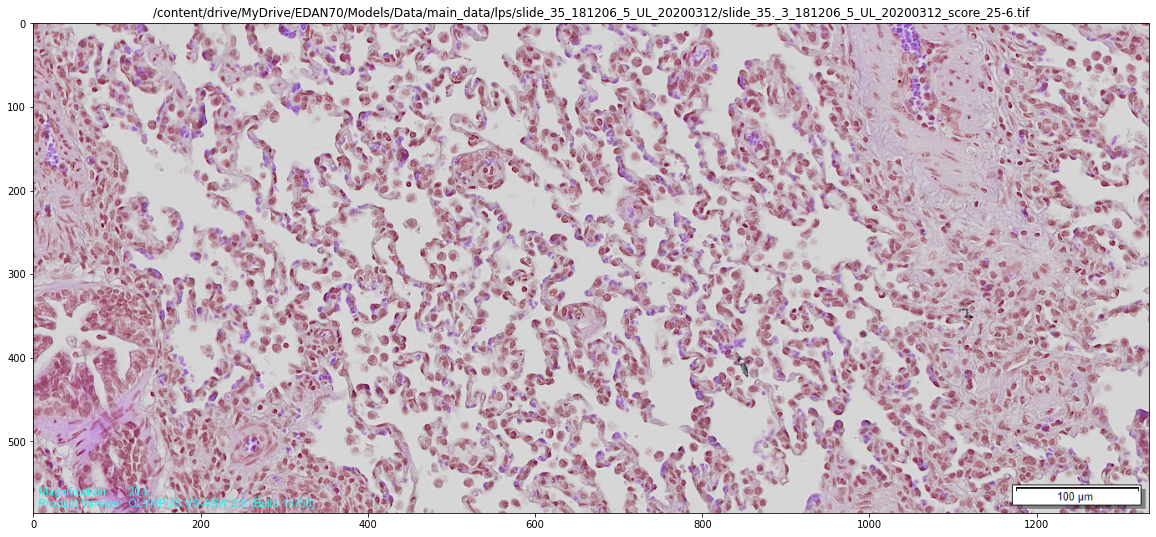

In [ ]:
## First, we need to read the images and convert them to a numpy array

import os
from PIL import Image
import glob
import cv2
import matplotlib.pyplot as plt
import sys


## Don't need this in colab environment
# sys.path.append('/home/salka/.conda/envs/myenv/lib/python3.7/site-packages')

## Directory of images
main_dir       = drive_data_dir
Classes_dir    = os.listdir(main_dir)
Images_dir     = {}
Images         = {}


## We  have two classes of "Control", "lps" images
for c in Classes_dir:
    if '.DS' in c:
      continue
      
    Images_dir[c] = os.listdir(os.path.join(main_dir,c))

Image_path    = []
## keys = ['Control','lps']
for k in Images_dir.keys():
    for v in Images_dir[k]:
        ## 10 directory for Control images
        ## 7  directory for lps images
        path = str(os.path.join(os.path.join(main_dir,k),v))+'/*'
        Image_path.append(glob.glob(path))
    Images[k] = Image_path
    Image_path = []
    
## Images    
##########################################################
## Reading the images and convert them to numpy array ##

img       = []
img_name  = []

np_img      = {}
np_img_name = {}
for k in Images.keys():
    for j in range(len(Images[k][:])):
        for i in range(len(Images[k][j][:])):
            img.append(cv2.imread(Images[k][j][i]))
            img_name.append(Images[k][j][i])
    np_img[k]=img
    np_img_name[k]=img_name
    img = []
    img_name = []
    print(len(np_img_name[k]))
    
##########################################################
## We have 140 control images and 70 lps images
## The size of control images are 586 x 1335 x 3
## The size of lps     images are 890 x 1674 x 3 and 586 x 1335 x 3

try: 
  if not os.path.exists('analysed_data'):
    os.makedirs('analysed_data')
    os.makedirs('analysed_data/data_4')
    os.makedirs('analysed_data/data_4/lps_larger')
    os.makedirs('analysed_data/data_4/lps_smaller')
    os.makedirs('analysed_data/data_4/Control')
except OSError:
  print('Error: Creating directory of data')
    

## Separate images to three different categories as Ctrl, lps_smaller, lps_larger images
for k in Images.keys():
    for j in range(len(np_img[k])):
        #Changing array position from 4 to 11 in colab
        name = np_img_name[k][j].split('/')[10]
        if k=='Control':
            cv2.imwrite("analysed_data/data_4/"+ k + '/'+name, np_img[k][j])
        else:
            if np_img[k][j].shape==(586,1335,3):
                cv2.imwrite("analysed_data/data_4/lps_smaller/"+name, np_img[k][j])
            else:
                cv2.imwrite("analysed_data/data_4/lps_larger/"+name, np_img[k][j])

##########################################################
## plotting some of the images ###########################
for i in range(0,2):
    plt.figure(figsize = (20,20))
    plt.imshow(np_img['Control'][i*10])
    plt.title(np_img_name['Control'][i*10])
    print(np_img['Control'][i*10].shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np_img['lps'][i*10])
    plt.title(np_img_name['lps'][i*10])
    print(np_img['lps'][i*10].shape)

### Custom labeling and train test split

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil, os

## Here images receive a label according to their scoring and the damage boundaries
## Then images are sorted into train and validation sets (cross-validation is used)

path = "analysed_data/data_4/"
des_path = 'analysed_data/data_4_separated/'
images = {}
labels={}
dirs = os.listdir( path )

## Create directories for data separation into 'train' and 'validation'    
try: 
  if os.path.exists('analysed_data/data_4_separated'):
    print(os.rmdir('analysed_data/data_4_separated'));
  if not os.path.exists('analysed_data/data_4_separated'):
    os.makedirs('analysed_data/data_4_separated/train')
    os.makedirs('analysed_data/data_4_separated/validation')
except OSError:
  print('Error: Could not directory of data, it already exists')

try:
  if not os.path.exists('analysed_data/data_4_separated/cropped_data_4'):
    os.makedirs('analysed_data/cropped_data_4/train')
    os.makedirs('analysed_data/cropped_data_4/validation')
except OSError:
  print('Error: Could not directory of data, it already exists')

# Boundaries for severity categories    
low = 10
mid = 25

# Create label file with scoring according to image name with score appended to end
for fold in dirs:
    images[fold] = glob.glob(path+fold+'/*')
    temp_labels = np.ones(len(images[fold]))*-1;

    idx = 0
    # Loop over each image and label according to boundaries above
    for slide in sorted(images[fold]):
      score = slide.split('score_')[1].split('.tif')[0]
      score_string = ''

      if '-' in score:
        score_string =  str(score.split('-')[0]) + '.' + str(score.split('-')[1])
      else:
        score_string = score

      score = float(score_string) 

      if score > mid:
        temp_labels[idx] = 2
      elif score > low:
        temp_labels[idx] = 1
      else:
        temp_labels[idx] = 0

      idx = idx + 1

    labels[fold] = temp_labels

# fold is 'control', 'lps_larger', 'lps_smaller'
for fold in dirs:
    # 18 total:
    # control     [14, 15, 16, 17, 18, 19, 20, 26, 28, 46, 47] add nr 9 ==> 12 controls
    # lps_larger  [42, 43, 44, 45] 
    # lps_smaller [35, 36, 41]
    
    ## The 3 different splits used for cross-validation
    # val_samples_nr = [42, 43, 14, 15, 16] # SPLIT 1 # 2 LPS, 3 CONTROL, completely in each set
  val_samples_nr = [44, 36, 19, 20, 28] # SPLIT 2 
    # val_samples_nr = [41, 35, 17, 18, 26]   # SPLIT 3 

  train_label = []
  validation_label = []

  train_samples = []
  validation_samples = []

  idx = 0
  # Check image slide_nr and compare to val_samples above, if match add to val
  for img in sorted(images[fold]):
    
    # Split out slide_nr
    slide_nr = int(img.split('/')[3].split('_')[1][0:2])
    
    if slide_nr in val_samples_nr:
      print(shutil.copyfile(img,'analysed_data/data_4_separated/validation/' + img.split('/')[3]))
      validation_label.append(labels[fold][idx])
      validation_samples.append(img)
    else:
      print(shutil.copyfile(img,'analysed_data/data_4_separated/train/' + img.split('/')[3]))
      train_label.append(labels[fold][idx])
      train_samples.append(img)
    
    idx += 1

  ## The list of train images are saved with corresponding labels
  with open ('analysed_data/data_4_separated/train/train_labels.txt','a+') as f:
      for k,n in zip(train_samples,train_label):
          print(k,n,file=f)
  f.close()
      
  ## The list of val images are saved with corresponding labels
  with open ('analysed_data/data_4_separated/validation/validation_labels.txt','a+') as f:    
      for i,b in zip(validation_samples,validation_label):
          print(i,b,file=f)
  f.close()

analysed_data/data_4_separated/train/slide_14_.3_6_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_._2_6_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_10_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_1_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_4_6_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_5_6_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_6_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_7_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_score_9-4.tif
analysed_data/data_4_separated/train/slide_14_8_191129_Pig_1_contral_MV_Base_mv_ecmo_control_005_sco

### Cropping of tiles

In [ ]:
## Here the original images are cut into smaller (224,224,3) tiles in each direcotry in 'analysed_data/data_4_separated/'

import cv2
import math

tile_size = (224,224)
offset = (224,224)

main_path = 'analysed_data/data_4_separated/'
dest_path = 'analysed_data/cropped_data_4/'

dirs = os.listdir(main_path)
print('Current directories \n')
print(dirs)
print(os.getcwd())

# If one wants to include entire image but with white space change floor to ceil below
# Iterate over each image and cut out as many 224 x 224 tiles as possible
for d in dirs:
    #if '.' in d: #catch potential residual files from .ipynb
    #  continue
    label_file = main_path+d+'/'+d+'_labels.txt'
    new_label_file = main_path+d+'/'+d+'_newlabels.txt'

    count = 0
    with open(label_file,'r') as f:
        with open(new_label_file,'+a') as f_out:
            for line in f:
                print('Cropping image ' + str(count))
                img_name = line.split()[0].split('/')[-1]
                img_label = line.split()[1]

                img = cv2.imread(main_path+d+'/'+img_name) # (586, 1335, 3)
                img_shape = img.shape
                base_name = img_name.replace(".tif","___")
                for i in range(int(math.floor(img_shape[0]/(offset[1] * 1.0)))):
                    for j in range(int(math.floor(img_shape[1]/(offset[0] * 1.0)))):
                        cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
                    # Debugging the tiles
                        if cropped_img.shape[0]<tile_size[0] or cropped_img.shape[1]<tile_size[1]:
                            shape = np.shape(cropped_img)
                            zero_pad_cropped_img=np.ones((224,224,3),dtype=int)*255
                            zero_pad_cropped_img[:shape[0],:shape[1]]=cropped_img
                            cv2.imwrite('analysed_data/cropped_data_4/'+ d +"/"+ base_name + str(i) + "_" + str(j) + ".tif", zero_pad_cropped_img)
                        else:    
                            cv2.imwrite('analysed_data/cropped_data_4/'+ d +"/"+ base_name + str(i) + "_" + str(j) + ".tif", cropped_img)
                        print(base_name + str(i) + "_" + str(j) + ".tif",img_label,file=f_out)
                count += 1
print("Tile splitting done!")

Current directories 

['validation', 'train']
/content
Cropping image 0
Cropping image 1
Cropping image 2
Cropping image 3
Cropping image 4
Cropping image 5
Cropping image 6
Cropping image 7
Cropping image 8
Cropping image 9
Cropping image 10
Cropping image 11
Cropping image 12
Cropping image 13
Cropping image 14
Cropping image 15
Cropping image 16
Cropping image 17
Cropping image 18
Cropping image 19
Cropping image 20
Cropping image 21
Cropping image 22
Cropping image 23
Cropping image 24
Cropping image 25
Cropping image 26
Cropping image 27
Cropping image 28
Cropping image 29
Cropping image 30
Cropping image 31
Cropping image 32
Cropping image 33
Cropping image 34
Cropping image 35
Cropping image 36
Cropping image 37
Cropping image 38
Cropping image 39
Cropping image 40
Cropping image 41
Cropping image 42
Cropping image 43
Cropping image 44
Cropping image 45
Cropping image 46
Cropping image 47
Cropping image 48
Cropping image 49
Cropping image 0
Cropping image 1
Cropping image 2
Crop

### Data Augmentation 

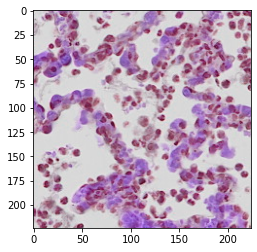

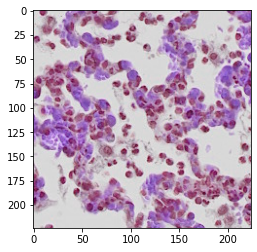

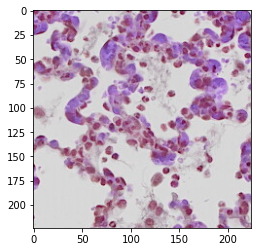

Data augmentation completed!


In [ ]:
## The random_process function applies augmentation to the images randomly from Control and lps folders in cropped_images
## Two random operation can be performed on images: flipping, rotation and brightness. Brigtness currently not used.

import numpy as np
import imageio as iio
from pathlib import Path
import cv2
from random import choice, random
import json
from collections import namedtuple
import glob
    
def random_process(im):
   
    #if random > 0.5:
    #  # Apply brightness
    #  brightness = 0.8 + 0.4*random()
    #  im = im*brightness
    #  im = np.clip(im, 0, 255) # Prevent too-large values
    
    if random() > 0.5:
      # Flip right-left
      im = np.fliplr(im)

    if random() > 0.5:
      # Rotate
      im = np.rot90(k=3, m = im)

    return im
        
DATASET_PATH = '/content/analysed_data/cropped_data_4/'

try:
  if not os.path.exists(DATASET_PATH + 'train_aug'):
    os.makedirs(DATASET_PATH + 'train_aug')
except OSError:
  print('Augmented training data directory already exists.')

images = []
show_samples = 3

for i, img in enumerate(sorted(os.listdir(DATASET_PATH + 'train/'))):
  
  if ".tif" in img:
    temp_img = cv2.imread(DATASET_PATH + 'train/' + img)
    temp_img = random_process(temp_img)
    if i < show_samples:
      plt.imshow(temp_img)
      plt.show()

    cv2.imwrite(DATASET_PATH + 'train_aug/' + img, temp_img)

print('Data augmentation completed!')

### Transfer learning with VGG16

In [ ]:
## The main script for reading train and validation data set and train the network 

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, Flatten, Input, MaxPooling2D, Activation, BatchNormalization, Concatenate, Dropout, Add, Dense
from keras.models import Model, model_from_json
from keras.callbacks import ModelCheckpoint, Callback

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split 

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path

# Build pretrained_model and combine our structure with VGG16
def pretrained_model(img_shape, num_classes,layer_type):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    
    #Input format
    keras_input = Input(shape=(224,224,3), name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(128, activation=layer_type, name='fc1')(x)
    x = Dense(128, activation=layer_type, name='fc2')(x)
    x = Dropout(0.5, name='dropout')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    pretrained_model.summary()

    return pretrained_model

# Loading different datasets

# train_DATA_PATH = "/content/analysed_data/cropped_data_4/train_aug/" # train with augmented data
train_DATA_PATH = "/content/analysed_data/cropped_data_4/train/"       # train with unaugmented data
validation_DATA_PATH = "/content/analysed_data/cropped_data_4/validation/"

# Define input shape and classes
input_shape = (224,224,3)
classes = ['low','medium','high']

### LOAD TRAINING SAMPLES AND LABELS ###

# Grab training and validation images
train_images      = glob.glob(train_DATA_PATH+'*.tif')
validation_images = glob.glob(validation_DATA_PATH+'*.tif')

n_t= len(train_images)
train_samples = np.zeros((n_t, input_shape[0], input_shape[1], 3), dtype=np.float32)
train_label = np.zeros((n_t,), int)

# Load train_labels      
with open(train_DATA_PATH+ '../../data_4_separated/train/train_newlabels.txt','r') as f:
    for ctr,line in zip(range(n_t),f):
        train_samples[ctr,:,:,:] = cv2.imread(train_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        train_label[ctr]   = la

# Convert matrix into float32    
for i in range(n_t):
    mod_img = train_samples[i,:, :].astype(np.float32)
    train_samples[i, :, :, :] = mod_img

# Clip too large value and rescale between -0.5 and 0.5
train_samples = np.clip(train_samples, 0, 255)    
train_samples /= 255
train_samples -= 0.5

### LOAD VALIDATION SAMPLES AND LABELS ###

n_v= len(validation_images) 
validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
validation_label = np.zeros((n_v,), int)

with open(validation_DATA_PATH+'../../data_4_separated/validation/'+'validation_newlabels.txt','r') as f:
    for ctr,line in zip(range(n_v),f):
        validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        validation_label[ctr]   = la

# Convert matrix into float32        
for i in range(n_v):
    mod_img = validation_samples[i,:, :].astype(np.float32)
    validation_samples[i, :, :, :] = mod_img

validation_samples = np.clip(validation_samples, 0, 255)    
validation_samples /= 255
validation_samples -= 0.5

### Train model ###

# Load model, define number of classes and activation function
model = pretrained_model(train_samples.shape[1:], 3,'relu')
model.summary()

for layer in model.layers:
    print(layer, layer.trainable)

# Define Callback to find precision, recall and F1-score metrics at epoch
class Metrics(Callback):
    def __init__(self, x, y):
        self.x = x
        self.y = y if (y.ndim == 1 or y.shape[1] == 1) else np.argmax(y, axis=1)
        self.reports = []

    def on_epoch_end(self, epoch, logs={}):
        y_hat = np.asarray(self.model.predict(self.x))
        y_hat = np.where(y_hat > 0.5, 1, 0) if (y_hat.ndim == 1 or y_hat.shape[1] == 1)  else np.argmax(y_hat, axis=1)
        report = classification_report(self.y,y_hat,output_dict=True)
        self.reports.append(report)
        return
   
    # Utility method
    def get(self, metrics, of_class):
        return [report[str(of_class)][metrics] for report in self.reports]

os.chdir('/content')

# Store metrics during training for both training and validation samples
# Each callback adds to epoch training time, use sparingly
metrics_multiclass_validation = Metrics(validation_samples,validation_label)
metrics_multiclass_training = Metrics(train_samples,train_label)

# Create model checkpoint to save model with best validation accuracy
mcp_save = ModelCheckpoint('best_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(train_samples, train_label,epochs=10, callbacks=[mcp_save, metrics_multiclass_validation,metrics_multiclass_training], validation_data=(validation_samples, validation_label), verbose=1)

print("Training done!")

## The final weights are saved as .h5 file and would be loaded to test on validation dataset
model.save_weights('final_weights.h5')

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               3211392   
_________________________________________________________________
fc2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 3)               

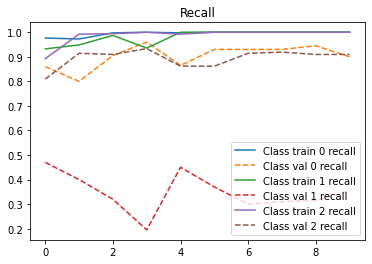

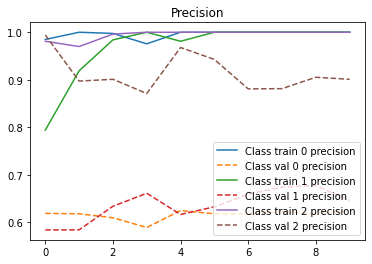

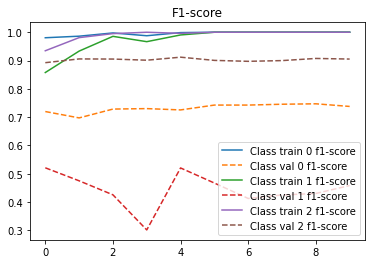

In [ ]:
# Plotting of precision, recall and F1-score progression during training

plt.close('all')
m = 'recall'
for c in [0,1,2]:
  plt.plot(metrics_multiclass_training.get(m,c), label='Class train {0} {1}'.format(c,m))
  plt.plot(metrics_multiclass_validation.get(m,c), label='Class val {0} {1}'.format(c,m),linestyle='dashed')
plt.title('Recall')
plt.legend(loc='lower right')
plt.show()

plt.close('all')
m = 'precision'
for c in [0,1,2]:
  plt.plot(metrics_multiclass_training.get(m,c), label='Class train {0} {1}'.format(c,m))
  plt.plot(metrics_multiclass_validation.get(m,c), label='Class val {0} {1}'.format(c,m),linestyle='dashed')
plt.title('Precision')
plt.legend(loc='lower right')
plt.show()

plt.close('all')
m = 'f1-score'
for c in [0,1,2]:
  plt.plot(metrics_multiclass_training.get(m,c), label='Class train {0} {1}'.format(c,m))
  plt.plot(metrics_multiclass_validation.get(m,c), label='Class val {0} {1}'.format(c,m),linestyle='dashed')
plt.title('F1-score')
plt.legend(loc='lower right')
plt.show()

## Results

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               3211392   
_________________________________________________________________
fc2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 3)               

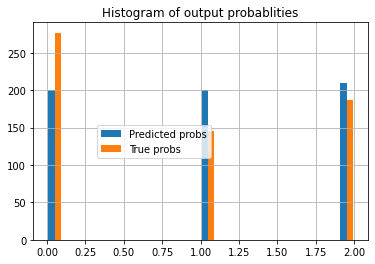

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


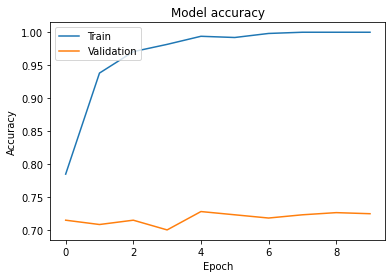

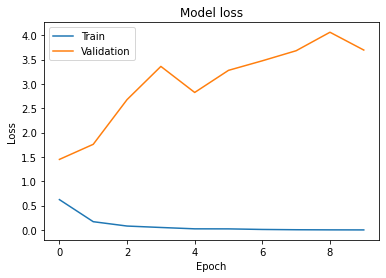

[[173  27   0]
 [104  90   6]
 [  0  29 181]]
              precision    recall  f1-score   support

           0       0.62      0.86      0.73       200
           1       0.62      0.45      0.52       200
           2       0.97      0.86      0.91       210

    accuracy                           0.73       610
   macro avg       0.74      0.73      0.72       610
weighted avg       0.74      0.73      0.72       610



In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from PIL import Image

from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import Callback
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model, model_from_json

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

## Saved .h5 or .hdf5 weights are used for predicting the labels of validation dataset
try:
  if not os.path.exists('results'):
    os.makedirs('results')
except:
  print("Results directory exists")

# Reading validation data set and convert to np arrays
validation_DATA_PATH = 'analysed_data/cropped_data_4/validation/'
validation_LABEL_PATH = '/content/analysed_data/data_4_separated/validation/validation_newlabels.txt'

input_shape = (224,224,3)
validation_images = glob.glob(validation_DATA_PATH+'*.tif')
n_v= len(validation_images) 
validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
validation_label = np.zeros((n_v,), int)

# Reading true labels of validation set
with open(validation_LABEL_PATH,'r') as f:
    for ctr,line in zip(range(n_v),f):
        validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        validation_label[ctr]   = la

# Convert matrix to float32        
for i in range(n_v):
    mod_img = validation_samples[i,:, :].astype(np.float32)
    validation_samples[i, :, :, :] = mod_img

validation_samples = np.clip(validation_samples, 0, 255)    
validation_samples /= 255
validation_samples -= 0.5

# Loading VGG16 with imagenet weights and custom top with saved weights from training
model_vgg16_conv = VGG16(weights='imagenet', include_top=False) 
 
#input format
keras_input = Input(shape=(224,224,3), name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(keras_input)

# Freeze layers of VGG16
for layer in model_vgg16_conv.layers:
    layer.trainable = False

layer_type = 'relu'
num_classes = 3

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(128, activation=layer_type, name='fc1')(x)
x = Dense(128, activation=layer_type, name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

#Create and compile our own model 
pretrained_model = Model(inputs=keras_input, outputs=x)
pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pretrained_model.summary()

# Load weights, select between best_weights (val_accuracy) and final_weights from last epoch
pretrained_model.load_weights('best_weights.05-0.73.hdf5')

# Make predictions on validation samples
preds = pretrained_model.predict(validation_samples)

print("Predicitons y_test_hat: " + str(preds))
# Max predictions in numpy array
preds_max = np.argmax(preds, axis=-1).astype(np.float32)

# Max predictions in normal vector
y_pred= []
for l in preds_max:
    y_pred.append(int(l))

# PROBABLY REMOVE THIS!!!!
pred_max = []
for i in range(len(preds)):
  pred_max.append(preds[i].argmax())

precise_scores = []
image_names = []

# Extract exact original score from image names
with open('/content/analysed_data/data_4_separated/validation/validation_newlabels.txt','r') as f: 
  for line in f:
    score = line.split('score_')[1].split('__')[0]
    score_string = ''

    if '-' in score:
      score_string =  str(score.split('-')[0]) + '.' + str(score.split('-')[1])
    else:
      score_string = score

    precise_scores.append(score_string)
    image_names.append(line)  
f.close()


print("Lower boundary " + str(low))
print("Mid boundary " + str(mid))

missclassified = []
# Print precise score and the wrongly predicted class
for k in range(len(preds)):
  if y_pred[k] != validation_label[k]:
    missclassified.append([precise_scores[k],y_pred[k]])
    print("Precise score " + str(precise_scores[k]) + " Wrong predicted class: " + str(y_pred[k]))

print(missclassified)
print(str(y_pred))

### The output probablity of validation data set
y_prob     = np.zeros([len(validation_label)])
y_prob     = preds[:,1].reshape(len(validation_label))

fig4 = plt.figure()
plt.hist([validation_label,np.array(y_pred)],20,label=['Predicted probs','True probs'])
plt.title('Histogram of output probablities')
fig4.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5))
plt.grid()
plt.savefig('results/Prob_histogram.png')
plt.show()

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

cfm = confusion_matrix(validation_label,np.array(y_pred))
print(cfm)

cr = classification_report(validation_label,np.array(y_pred))
print(cr)

## Regression model (incomplete)


In [ ]:
## REGRESSION MODEL

# TODO to make it work:
#1 Fix reading of labels file to print exact value, not low, mid, high
#2 Check correct activation functions in model
#3 Make new results function that reads the new label file

# The main script for reading train and validation data set and train the network 
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, Flatten, Input, MaxPooling2D, Activation, BatchNormalization, Concatenate, Dropout, Add, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint


################################################################################
# Model definition for regression
def pretrained_model(img_shape, num_classes,layer_type):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    
    #input format
    keras_input = Input(shape=(224,224,3), name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(64, activation=layer_type, name='fc1')(x)
    x = Dense(64, activation=layer_type, name='fc2')(x)
    x = Dense(num_classes, activation='relu', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    
    # REGRESSION–SPECIFIC: MeanSquaredError instead of crossentropy-loss
    pretrained_model.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])
    pretrained_model.summary()

    return pretrained_model

################################################################################
# Training data (data_4)
train_DATA_PATH = "/content/analysed_data/cropped_data_4/train/"
validation_DATA_PATH = "/content/analysed_data/cropped_data_4/validation/"

input_shape = (224,224,3)
classes = ['low','medium','high']

train_images      = glob.glob(train_DATA_PATH+'*.tif')
validation_images = glob.glob(validation_DATA_PATH+'*.tif')

n_t= len(train_images)
train_samples = np.zeros((n_t, input_shape[0], input_shape[1], 3), dtype=np.float32)
train_label = np.zeros((n_t,), int)

       
with open(train_DATA_PATH+ '../../data_4_separated/train/train_newlabels.txt','r') as f:
    for ctr,line in zip(range(n_t),f):
        train_samples[ctr,:,:,:] = cv2.imread(train_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        train_label[ctr]   = la
        
for i in range(n_t):
    mod_img = train_samples[i,:, :].astype(np.float32)
    train_samples[i, :, :, :] = mod_img

#print(samples.dtype)
train_samples = np.clip(train_samples, 0, 255)    
train_samples /= 255
train_samples -= 0.5

################################################################################
# Validation dataset
n_v= len(validation_images) 
validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
validation_label = np.zeros((n_v,), int)

with open(validation_DATA_PATH+'../../data_4_separated/validation/'+'validation_newlabels.txt','r') as f:
    for ctr,line in zip(range(n_v),f):
        validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        #print("Train label was: " + str(la))
        validation_label[ctr]   = la
        
for i in range(n_v):
    mod_img = validation_samples[i,:, :].astype(np.float32)
    validation_samples[i, :, :, :] = mod_img

validation_samples = np.clip(validation_samples, 0, 255)    
validation_samples /= 255
validation_samples -= 0.5

################################################################################
## Training the model
model = pretrained_model(train_samples.shape[1:], 1,'relu') ## REGRESSION: number of classes 1 instead of 3
model.summary()

for layer in model.layers:
    print(layer, layer.trainable)

mcp_save = ModelCheckpoint('best_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(train_samples, train_label,epochs=10, callbacks=[mcp_save], validation_data=(validation_samples, validation_label), verbose=1)
print("Training done!")

## The weights are saved as .h5 file and would be loaded to test on validation dataset
model.save_weights('final_weights.h5') 


KeyboardInterrupt: ignored